<a href="https://colab.research.google.com/github/who0liebo0lie/ArticleTraffic/blob/main/Article_Patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

LLM for Article Similarities

Starting to scrape JW Library Life Stories...


<ipython-input-1-afab53ea8d63>:77: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
Scraping life stories: 100%|██████████| 6/6 [01:05<00:00, 10.98s/it]
<ipython-input-1-afab53ea8d63>:441: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
<ipython-input-1-afab53ea8d63>:442: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
<ipython-input-1-afab53ea8d63>:443: UserWarning: This pattern is interpreted as a regula


Dataset Summary:
Total articles: 6
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4

Dataset Summary:
Total articles: 6
Popular articles: 1
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4
  - Family stories: 5

Dataset Summary:
Total articles: 6
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4

Dataset Summary:
Total articles: 6
Popular articles: 1
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4
  - Family stories: 5

Creating popularity analysis visualizations...


<ipython-input-1-afab53ea8d63>:615: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([regular_words, popular_words], labels=['Regular', 'Popular'])
<ipython-input-1-afab53ea8d63>:624: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([regular_refs, popular_refs], labels=['Regular', 'Popular'])


Popularity analysis saved to 'jw_popularity_analysis.png'


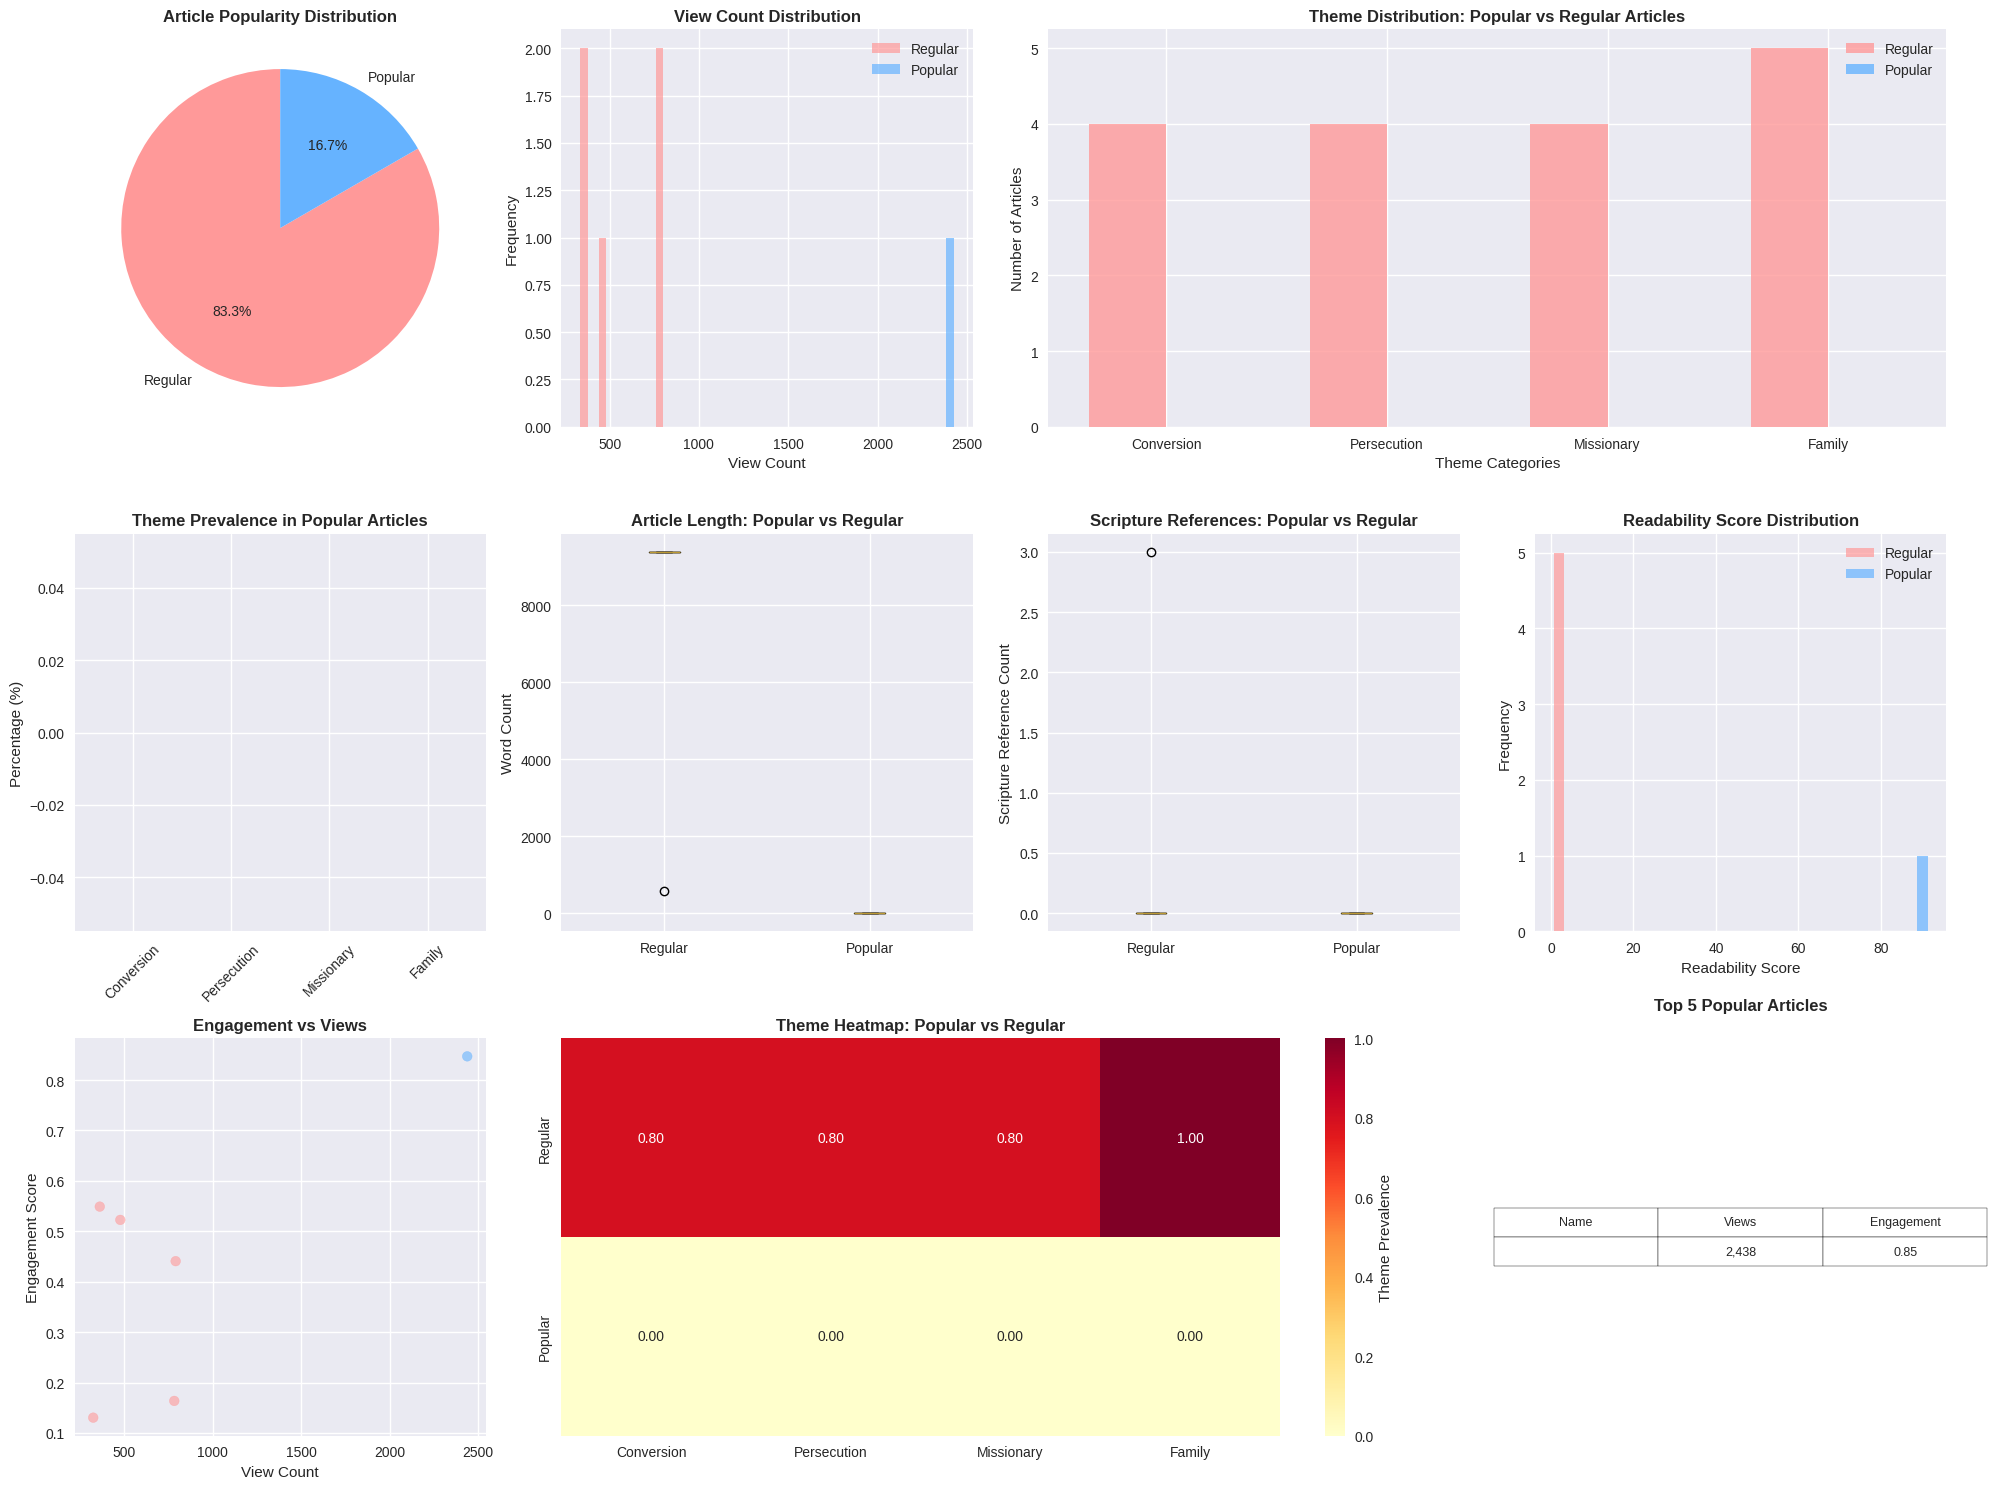

/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/usr/local/lib/python3.11/dist-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


Detailed theme analysis saved to 'jw_detailed_theme_analysis.png'


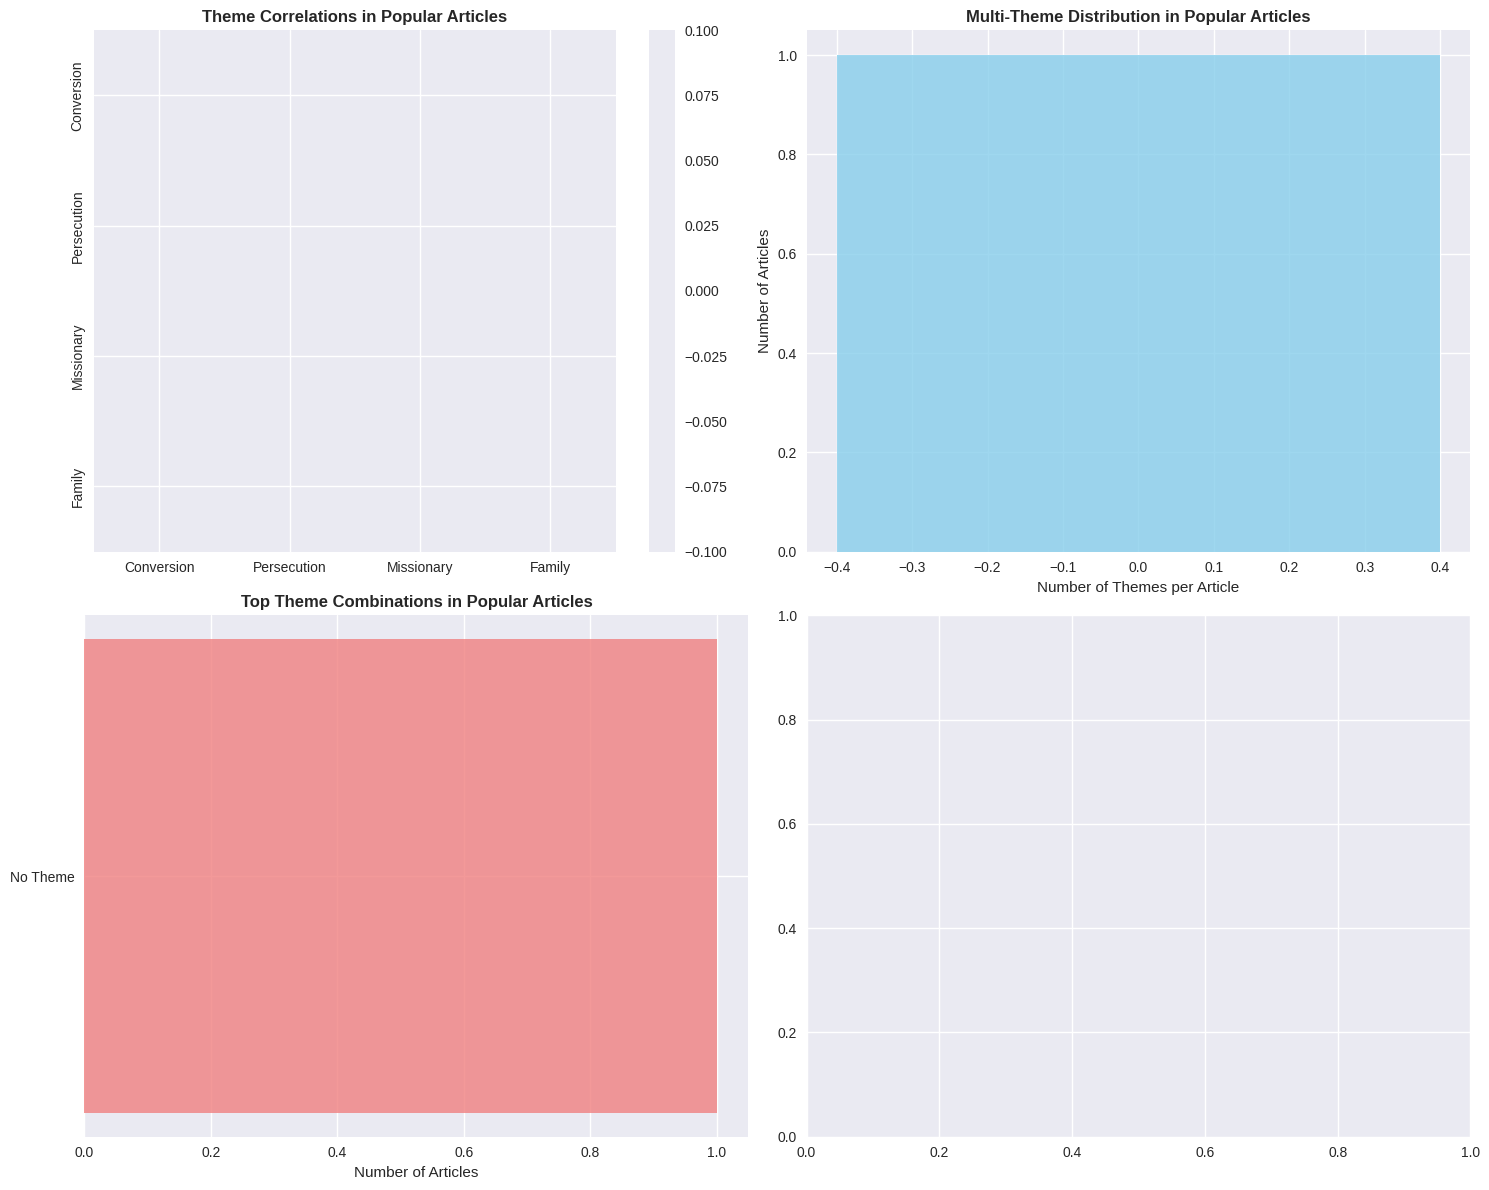


POPULARITY ANALYSIS INSIGHTS

Dataset Overview:
  Total articles: 6
  Popular articles: 1 (16.7%)
  Regular articles: 5 (83.3%)

Engagement Metrics:
  Popular articles avg views: 2438
  Regular articles avg views: 547
  Popular articles avg engagement: 0.85
  Regular articles avg engagement: 0.36

Content Characteristics:
  Popular articles avg word count: 4
  Regular articles avg word count: 7628
  Popular articles avg scripture refs: 0.0
  Regular articles avg scripture refs: 0.6

Theme Analysis:
  Conversion theme:
    Popular articles: 0.0%
    Regular articles: 80.0%
    Difference: -80.0% points
  Persecution theme:
    Popular articles: 0.0%
    Regular articles: 80.0%
    Difference: -80.0% points
  Missionary theme:
    Popular articles: 0.0%
    Regular articles: 80.0%
    Difference: -80.0% points
  Family theme:
    Popular articles: 0.0%
    Regular articles: 100.0%
    Difference: -100.0% points


Successfully scraped 6 life stories!
Data saved to jw_life_stories_dataset

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
from urllib.parse import urljoin, urlparse
import json
from datetime import datetime
import logging
from typing import List, Dict, Optional
import csv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class JWLibraryScraper:
    def __init__(self, base_url: str = "https://wol.jw.org"):
        """
        Initialize JW Library scraper for Life Stories

        Args:
            base_url: Base URL for JW Library
        """
        self.base_url = base_url
        self.session = requests.Session()
        self.life_stories = []

        # Setup headers to avoid blocking
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }
        self.session.headers.update(self.headers)

        # Setup logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def get_life_stories_index(self, index_url: str) -> List[Dict]:
        """
        Extract all life story links from the index page

        Args:
            index_url: URL of the life stories index page

        Returns:
            List of dictionaries containing story metadata
        """
        try:
            response = self.session.get(index_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')
            stories = []

            # Find all life story entries
            # Based on the structure shown in your screenshot
            story_links = soup.find_all('a', href=re.compile(r'/wol/d/r1/lp-e/'))

            for link in story_links:
                story_info = self._extract_story_metadata(link)
                if story_info:
                    stories.append(story_info)

            # Alternative approach: look for specific patterns in the list
            name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
            for entry in name_entries:
                parent = entry.parent
                if parent and parent.name == 'a':
                    story_info = self._extract_story_metadata(parent)
                    if story_info and story_info not in stories:
                        stories.append(story_info)

            self.logger.info(f"Found {len(stories)} life stories in index")
            return stories

        except Exception as e:
            self.logger.error(f"Error extracting life stories index: {str(e)}")
            return []

    def _extract_story_metadata(self, link_element) -> Optional[Dict]:
        """
        Extract metadata from a story link element

        Args:
            link_element: BeautifulSoup element containing the link

        Returns:
            Dictionary with story metadata
        """
        try:
            href = link_element.get('href')
            if not href:
                return None

            # Build full URL
            full_url = urljoin(self.base_url, href)

            # Extract name and reference from text
            text = link_element.get_text().strip()

            # Parse the text format: "LastName, FirstName: reference"
            if ':' in text:
                name_part, reference = text.split(':', 1)
                name_part = name_part.strip()
                reference = reference.strip()
            else:
                name_part = text
                reference = ""

            # Extract article ID from URL
            article_id = href.split('/')[-1] if '/' in href else href

            return {
                'name': name_part,
                'reference': reference,
                'url': full_url,
                'article_id': article_id,
                'text': text
            }

        except Exception as e:
            self.logger.error(f"Error extracting story metadata: {str(e)}")
            return None

    def scrape_individual_story(self, story_url: str) -> Optional[Dict]:
        """
        Scrape content from an individual life story article

        Args:
            story_url: URL of the individual story

        Returns:
            Dictionary containing the full article data
        """
        try:
            # Add random delay to be respectful
            time.sleep(random.uniform(1, 3))

            response = self.session.get(story_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract article content
            article_data = {
                'url': story_url,
                'title': self._extract_title(soup),
                'subtitle': self._extract_subtitle(soup),
                'content': self._extract_content(soup),
                'scripture_references': self._extract_scripture_references(soup),
                'year_published': self._extract_publication_year(soup),
                'word_count': 0,
                'paragraphs': [],
                'key_points': [],
                'scraped_at': datetime.now().isoformat()
            }

            # Calculate word count
            if article_data['content']:
                article_data['word_count'] = len(article_data['content'].split())

            # Extract paragraphs for detailed analysis
            article_data['paragraphs'] = self._extract_paragraphs(soup)

            # Extract key points or highlights
            article_data['key_points'] = self._extract_key_points(soup)

            return article_data

        except Exception as e:
            self.logger.error(f"Error scraping story from {story_url}: {str(e)}")
            return None

    def _extract_title(self, soup) -> str:
        """Extract article title"""
        selectors = [
            'h1',
            '.articleTitle',
            '.title',
            '#title',
            '[data-pid="1"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return "Unknown Title"

    def _extract_subtitle(self, soup) -> str:
        """Extract article subtitle"""
        selectors = [
            'h2',
            '.subtitle',
            '.articleSubtitle',
            '[data-pid="2"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return ""

    def _extract_content(self, soup) -> str:
        """Extract main article content"""
        # Remove unwanted elements
        for element in soup(['script', 'style', 'nav', 'header', 'footer']):
            element.decompose()

        # Try different content selectors
        content_selectors = [
            '.bodyTxt',
            '.article',
            '.content',
            '#article',
            '.articleContent',
            'main'
        ]

        for selector in content_selectors:
            content_div = soup.select_one(selector)
            if content_div:
                return content_div.get_text().strip()

        # Fallback: get all paragraph text
        paragraphs = soup.find_all('p')
        if paragraphs:
            return '\n'.join([p.get_text().strip() for p in paragraphs if p.get_text().strip()])

        return soup.get_text().strip()

    def _extract_paragraphs(self, soup) -> List[str]:
        """Extract individual paragraphs for analysis"""
        paragraphs = []

        # Look for numbered paragraphs (common in JW publications)
        numbered_paras = soup.find_all(attrs={'data-pid': True})
        if numbered_paras:
            for para in numbered_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:  # Filter out very short paragraphs
                    paragraphs.append(text)
        else:
            # Fallback to regular paragraphs
            regular_paras = soup.find_all('p')
            for para in regular_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:
                    paragraphs.append(text)

        return paragraphs

    def _extract_scripture_references(self, soup) -> List[str]:
        """Extract scripture references from the article"""
        references = []

        # Look for scripture citation patterns
        scripture_patterns = [
            r'\b\d?\s?[A-Z][a-z]+\s+\d+:\d+(?:-\d+)?\b',  # Book chapter:verse
            r'\b[A-Z][a-z]+\.\s+\d+:\d+(?:-\d+)?\b'       # Book. chapter:verse
        ]

        text = soup.get_text()
        for pattern in scripture_patterns:
            matches = re.findall(pattern, text)
            references.extend(matches)

        # Also look for elements with scripture-specific classes
        scripture_elements = soup.find_all(class_=re.compile(r'scripture|citation|verse'))
        for element in scripture_elements:
            ref_text = element.get_text().strip()
            if ref_text:
                references.append(ref_text)

        return list(set(references))  # Remove duplicates

    def _extract_publication_year(self, soup) -> Optional[str]:
        """Extract publication year"""
        # Look for publication info
        pub_info = soup.find(class_=re.compile(r'pub|date|year'))
        if pub_info:
            text = pub_info.get_text()
            years = re.findall(r'\b(19|20)\d{2}\b', text)
            if years:
                return years[0]

        # Check meta tags
        meta_date = soup.find('meta', attrs={'name': 'date'})
        if meta_date:
            return meta_date.get('content', '')

        return None

    def _extract_key_points(self, soup) -> List[str]:
        """Extract key points or highlights from the article"""
        key_points = []

        # Look for bold text (often key points)
        bold_elements = soup.find_all(['b', 'strong'])
        for element in bold_elements:
            text = element.get_text().strip()
            if len(text) > 10 and len(text) < 200:  # Reasonable length for key points
                key_points.append(text)

        # Look for lists
        list_items = soup.find_all('li')
        for item in list_items:
            text = item.get_text().strip()
            if len(text) > 10:
                key_points.append(text)

        return key_points[:10]  # Limit to top 10 key points

    def scrape_all_stories(self, index_url: str) -> pd.DataFrame:
        """
        Scrape all life stories and return as DataFrame for model evaluation

        Args:
            index_url: URL of the life stories index page

        Returns:
            pandas DataFrame with one row per article
        """
        # Get list of all stories
        stories_index = self.get_life_stories_index(index_url)

        if not stories_index:
            self.logger.error("No stories found in index")
            return pd.DataFrame()

        # Scrape each individual story
        all_stories_data = []

        for story_info in tqdm(stories_index, desc="Scraping life stories"):
            self.logger.info(f"Scraping: {story_info['name']}")

            story_data = self.scrape_individual_story(story_info['url'])

            if story_data:
                # Combine index info with scraped content
                combined_data = {**story_info, **story_data}
                all_stories_data.append(combined_data)
            else:
                # Still add the index info even if scraping failed
                story_info['content'] = ""
                story_info['word_count'] = 0
                story_info['scraped_at'] = datetime.now().isoformat()
                all_stories_data.append(story_info)

        # Convert to DataFrame
        df = pd.DataFrame(all_stories_data)

        # Add additional columns for model evaluation
        if not df.empty:
            df = self._add_evaluation_columns(df)
            df = self._add_popularity_simulation(df)

        self.logger.info(f"Successfully scraped {len(df)} life stories")
        return df

    def _add_popularity_simulation(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Randomly assign popularity to 1/4 of articles and simulate engagement metrics

        Args:
            df: DataFrame with scraped articles

        Returns:
            DataFrame with popularity metrics
        """
        n_articles = len(df)
        n_popular = max(1, n_articles // 4)  # 1/4 of articles are popular

        # Randomly select popular articles
        popular_indices = random.sample(range(n_articles), n_popular)

        # Initialize popularity columns
        df['is_popular'] = False
        df['view_count'] = 0
        df['engagement_score'] = 0.0
        df['popularity_rank'] = 0

        # Set popular articles
        df.loc[popular_indices, 'is_popular'] = True

        # Simulate view counts
        # Popular articles: 1000-5000 views
        # Regular articles: 50-800 views
        for idx in df.index:
            if df.loc[idx, 'is_popular']:
                df.loc[idx, 'view_count'] = random.randint(1000, 5000)
                df.loc[idx, 'engagement_score'] = random.uniform(0.7, 1.0)
            else:
                df.loc[idx, 'view_count'] = random.randint(50, 800)
                df.loc[idx, 'engagement_score'] = random.uniform(0.1, 0.6)

        # Calculate popularity rank
        df['popularity_rank'] = df['view_count'].rank(method='dense', ascending=False).astype(int)

        self.logger.info(f"Assigned popularity to {n_popular} out of {n_articles} articles")
        return df

    def _add_evaluation_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add columns useful for model evaluation

        Args:
            df: DataFrame with scraped articles

        Returns:
            DataFrame with additional evaluation columns
        """
        # Text length metrics
        df['char_count'] = df['content'].fillna('').str.len()
        df['sentence_count'] = df['content'].fillna('').apply(lambda x: len(x.split('.')) if x else 0)
        df['avg_sentence_length'] = df.apply(lambda x: x['char_count'] / x['sentence_count'] if x['sentence_count'] > 0 else 0, axis=1)

        # Content categorization
        df['has_scripture_refs'] = df['scripture_references'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
        df['scripture_ref_count'] = df['scripture_references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

        # Text complexity indicators
        df['unique_word_ratio'] = df['content'].fillna('').apply(self._calculate_unique_word_ratio)

        # Story themes (basic keyword matching)
        df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
        df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
        df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
        df['theme_family'] = df['content'].fillna('').str.contains(r'\b(family|children|marriage|husband|wife|parent)\b', case=False, regex=True)

        # Readability score (simple version)
        df['readability_score'] = df.apply(self._simple_readability_score, axis=1)

        return df

    def _calculate_unique_word_ratio(self, text: str) -> float:
        """Calculate ratio of unique words to total words"""
        if not text:
            return 0.0

        words = text.lower().split()
        if not words:
            return 0.0

        unique_words = set(words)
        return len(unique_words) / len(words)

    def _simple_readability_score(self, row) -> float:
        """Calculate a simple readability score"""
        if not row['content'] or row['word_count'] == 0:
            return 0.0

        # Simple formula based on average sentence length
        avg_words_per_sentence = row['word_count'] / max(row['sentence_count'], 1)

        # Score from 0-100, where higher = more readable
        # Penalize very long sentences
        if avg_words_per_sentence < 15:
            return 100 - (avg_words_per_sentence * 2)
        else:
            return max(0, 70 - (avg_words_per_sentence - 15) * 3)

    def save_for_model_evaluation(self, df: pd.DataFrame, output_file: str, format: str = 'csv'):
        """
        Save the scraped data in format suitable for model evaluation

        Args:
            df: DataFrame with scraped articles
            output_file: Output file path
            format: Output format ('csv', 'json', 'parquet')
        """
        if df.empty:
            self.logger.error("No data to save")
            return

        # Prepare columns for model evaluation
        eval_columns = [
            'name', 'title', 'content', 'word_count', 'char_count',
            'sentence_count', 'scripture_ref_count', 'year_published',
            'theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family',
            'readability_score', 'unique_word_ratio', 'is_popular', 'view_count',
            'engagement_score', 'popularity_rank', 'url', 'scraped_at'
        ]

        # Only include columns that exist
        available_columns = [col for col in eval_columns if col in df.columns]
        eval_df = df[available_columns].copy()

        # Clean data for model evaluation
        eval_df = eval_df.fillna('')

        # Save in requested format
        if format.lower() == 'csv':
            eval_df.to_csv(output_file, index=False, encoding='utf-8')
        elif format.lower() == 'json':
            eval_df.to_json(output_file, orient='records', indent=2)
        elif format.lower() == 'parquet':
            eval_df.to_parquet(output_file, index=False)
        else:
            raise ValueError(f"Unsupported format: {format}")

        self.logger.info(f"Saved {len(eval_df)} articles to {output_file}")

        # Print summary statistics
        print(f"\nDataset Summary:")
        print(f"Total articles: {len(eval_df)}")
        print(f"Average word count: {eval_df['word_count'].mean():.1f}")
        print(f"Articles with scripture references: {eval_df['scripture_ref_count'].gt(0).sum()}")
        print(f"Theme distribution:")
        print(f"  - Conversion stories: {eval_df['theme_conversion'].sum()}")
        print(f"  - Persecution stories: {eval_df['theme_persecution'].sum()}")
        print(f"  - Missionary stories: {eval_df['theme_missionary'].sum()}")
        self.logger.info(f"Saved {len(eval_df)} articles to {output_file}")

        # Print summary statistics
        print(f"\nDataset Summary:")
        print(f"Total articles: {len(eval_df)}")
        print(f"Popular articles: {eval_df['is_popular'].sum()}")
        print(f"Average word count: {eval_df['word_count'].mean():.1f}")
        print(f"Articles with scripture references: {eval_df['scripture_ref_count'].gt(0).sum()}")
        print(f"Theme distribution:")
        print(f"  - Conversion stories: {eval_df['theme_conversion'].sum()}")
        print(f"  - Persecution stories: {eval_df['theme_persecution'].sum()}")
        print(f"  - Missionary stories: {eval_df['theme_missionary'].sum()}")
        print(f"  - Family stories: {eval_df['theme_family'].sum()}")

    def create_popularity_visualizations(self, df: pd.DataFrame, save_plots: bool = True):
        """
        Create comprehensive visualizations showing themes in popular vs regular articles

        Args:
            df: DataFrame with scraped articles and popularity data
            save_plots: Whether to save plots to files
        """
        if df.empty:
            print("No data available for visualization")
            return

        # Set up the plotting style
        plt.style.use('seaborn-v0_8')
        sns.set_palette("husl")

        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Popularity Distribution Pie Chart
        ax1 = plt.subplot(3, 4, 1)
        popularity_counts = df['is_popular'].value_counts()
        colors = ['#ff9999', '#66b3ff']
        plt.pie(popularity_counts.values, labels=['Regular', 'Popular'], autopct='%1.1f%%',
                colors=colors, startangle=90)
        plt.title('Article Popularity Distribution', fontsize=12, fontweight='bold')

        # 2. View Count Distribution
        ax2 = plt.subplot(3, 4, 2)
        popular_views = df[df['is_popular'] == True]['view_count']
        regular_views = df[df['is_popular'] == False]['view_count']

        plt.hist([regular_views, popular_views], bins=20, alpha=0.7,
                label=['Regular', 'Popular'], color=['#ff9999', '#66b3ff'])
        plt.xlabel('View Count')
        plt.ylabel('Frequency')
        plt.title('View Count Distribution', fontsize=12, fontweight='bold')
        plt.legend()

        # 3. Theme Comparison Bar Chart
        ax3 = plt.subplot(3, 4, (3, 4))
        themes = ['theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family']
        popular_themes = df[df['is_popular'] == True][themes].sum()
        regular_themes = df[df['is_popular'] == False][themes].sum()

        x = np.arange(len(themes))
        width = 0.35

        theme_labels = ['Conversion', 'Persecution', 'Missionary', 'Family']
        plt.bar(x - width/2, regular_themes, width, label='Regular', color='#ff9999', alpha=0.8)
        plt.bar(x + width/2, popular_themes, width, label='Popular', color='#66b3ff', alpha=0.8)

        plt.xlabel('Theme Categories')
        plt.ylabel('Number of Articles')
        plt.title('Theme Distribution: Popular vs Regular Articles', fontsize=12, fontweight='bold')
        plt.xticks(x, theme_labels)
        plt.legend()

        # 4. Theme Percentage in Popular Articles
        ax4 = plt.subplot(3, 4, 5)
        popular_df = df[df['is_popular'] == True]
        if not popular_df.empty:
            theme_percentages = popular_df[themes].mean() * 100
            plt.bar(theme_labels, theme_percentages, color='#66b3ff', alpha=0.8)
            plt.ylabel('Percentage (%)')
            plt.title('Theme Prevalence in Popular Articles', fontsize=12, fontweight='bold')
            plt.xticks(rotation=45)

        # 5. Word Count vs Popularity
        ax5 = plt.subplot(3, 4, 6)
        popular_words = df[df['is_popular'] == True]['word_count']
        regular_words = df[df['is_popular'] == False]['word_count']

        plt.boxplot([regular_words, popular_words], labels=['Regular', 'Popular'])
        plt.ylabel('Word Count')
        plt.title('Article Length: Popular vs Regular', fontsize=12, fontweight='bold')

        # 6. Scripture References vs Popularity
        ax6 = plt.subplot(3, 4, 7)
        popular_refs = df[df['is_popular'] == True]['scripture_ref_count']
        regular_refs = df[df['is_popular'] == False]['scripture_ref_count']

        plt.boxplot([regular_refs, popular_refs], labels=['Regular', 'Popular'])
        plt.ylabel('Scripture Reference Count')
        plt.title('Scripture References: Popular vs Regular', fontsize=12, fontweight='bold')

        # 7. Readability Score Comparison
        ax7 = plt.subplot(3, 4, 8)
        popular_readability = df[df['is_popular'] == True]['readability_score']
        regular_readability = df[df['is_popular'] == False]['readability_score']

        plt.hist([regular_readability, popular_readability], bins=15, alpha=0.7,
                label=['Regular', 'Popular'], color=['#ff9999', '#66b3ff'])
        plt.xlabel('Readability Score')
        plt.ylabel('Frequency')
        plt.title('Readability Score Distribution', fontsize=12, fontweight='bold')
        plt.legend()

        # 8. Engagement Score vs View Count Scatter
        ax8 = plt.subplot(3, 4, 9)
        colors = ['#ff9999' if not pop else '#66b3ff' for pop in df['is_popular']]
        plt.scatter(df['view_count'], df['engagement_score'], c=colors, alpha=0.6)
        plt.xlabel('View Count')
        plt.ylabel('Engagement Score')
        plt.title('Engagement vs Views', fontsize=12, fontweight='bold')

        # 9. Theme Heatmap
        ax9 = plt.subplot(3, 4, (10, 11))
        theme_matrix = df.groupby('is_popular')[themes].mean()
        theme_matrix.index = ['Regular', 'Popular']
        theme_matrix.columns = theme_labels

        sns.heatmap(theme_matrix, annot=True, cmap='YlOrRd', fmt='.2f',
                   cbar_kws={'label': 'Theme Prevalence'})
        plt.title('Theme Heatmap: Popular vs Regular', fontsize=12, fontweight='bold')

        # 10. Top Popular Articles Table
        ax10 = plt.subplot(3, 4, 12)
        ax10.axis('tight')
        ax10.axis('off')

        top_popular = df[df['is_popular'] == True].nlargest(5, 'view_count')[
            ['name', 'view_count', 'engagement_score']
        ]

        if not top_popular.empty:
            table_data = []
            for _, row in top_popular.iterrows():
                name = row['name'][:20] + '...' if len(row['name']) > 20 else row['name']
                table_data.append([name, f"{row['view_count']:,}", f"{row['engagement_score']:.2f}"])

            table = ax10.table(cellText=table_data,
                             colLabels=['Name', 'Views', 'Engagement'],
                             cellLoc='center', loc='center')
            table.auto_set_font_size(False)
            table.set_fontsize(9)
            table.scale(1.2, 1.5)
            ax10.set_title('Top 5 Popular Articles', fontsize=12, fontweight='bold', pad=20)

        plt.tight_layout()

        if save_plots:
            plt.savefig('jw_popularity_analysis.png', dpi=300, bbox_inches='tight')
            print("Popularity analysis saved to 'jw_popularity_analysis.png'")

        plt.show()

        # Create additional detailed analysis
        self._create_detailed_theme_analysis(df, save_plots)

    def _create_detailed_theme_analysis(self, df: pd.DataFrame, save_plots: bool = True):
        """
        Create detailed theme analysis for popular articles

        Args:
            df: DataFrame with article data
            save_plots: Whether to save plots
        """
        popular_df = df[df['is_popular'] == True]

        if popular_df.empty:
            print("No popular articles found for detailed analysis")
            return

        # Create theme correlation analysis
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # 1. Theme co-occurrence in popular articles
        themes = ['theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family']
        theme_labels = ['Conversion', 'Persecution', 'Missionary', 'Family']

        # Calculate theme correlations
        theme_corr = popular_df[themes].corr()
        theme_corr.index = theme_labels
        theme_corr.columns = theme_labels

        sns.heatmap(theme_corr, annot=True, cmap='RdBu_r', center=0,
                   square=True, ax=axes[0, 0])
        axes[0, 0].set_title('Theme Correlations in Popular Articles', fontweight='bold')

        # 2. Multi-theme articles analysis
        popular_df_themes = popular_df[themes].copy()
        popular_df_themes.columns = theme_labels
        popular_df_themes['theme_count'] = popular_df_themes.sum(axis=1)

        theme_count_dist = popular_df_themes['theme_count'].value_counts().sort_index()
        axes[0, 1].bar(theme_count_dist.index, theme_count_dist.values,
                      color='skyblue', alpha=0.8)
        axes[0, 1].set_xlabel('Number of Themes per Article')
        axes[0, 1].set_ylabel('Number of Articles')
        axes[0, 1].set_title('Multi-Theme Distribution in Popular Articles', fontweight='bold')

        # 3. Theme combinations
        theme_combinations = []
        for _, row in popular_df.iterrows():
            active_themes = []
            for theme, label in zip(themes, theme_labels):
                if row[theme]:
                    active_themes.append(label)
            if active_themes:
                theme_combinations.append('+'.join(sorted(active_themes)))
            else:
                theme_combinations.append('No Theme')

        combo_counts = Counter(theme_combinations)
        top_combos = dict(combo_counts.most_common(8))

        axes[1, 0].barh(list(top_combos.keys()), list(top_combos.values()),
                       color='lightcoral', alpha=0.8)
        axes[1, 0].set_xlabel('Number of Articles')
        axes[1, 0].set_title('Top Theme Combinations in Popular Articles', fontweight='bold')

        # 4. Performance metrics by theme
        theme_performance = {}
        for theme, label in zip(themes, theme_labels):
            theme_articles = popular_df[popular_df[theme] == True]
            if not theme_articles.empty:
                theme_performance[label] = {
                    'avg_views': theme_articles['view_count'].mean(),
                    'avg_engagement': theme_articles['engagement_score'].mean(),
                    'count': len(theme_articles)
                }

        if theme_performance:
            perf_df = pd.DataFrame(theme_performance).T

            # Normalize metrics for better visualization
            perf_df['views_norm'] = perf_df['avg_views'] / perf_df['avg_views'].max()
            perf_df['engagement_norm'] = perf_df['avg_engagement'] / perf_df['avg_engagement'].max()

            x = np.arange(len(perf_df))
            width = 0.35

            axes[1, 1].bar(x - width/2, perf_df['views_norm'], width,
                          label='Normalized Views', alpha=0.8)
            axes[1, 1].bar(x + width/2, perf_df['engagement_norm'], width,
                          label='Normalized Engagement', alpha=0.8)

            axes[1, 1].set_xlabel('Theme')
            axes[1, 1].set_ylabel('Normalized Performance')
            axes[1, 1].set_title('Theme Performance in Popular Articles', fontweight='bold')
            axes[1, 1].set_xticks(x)
            axes[1, 1].set_xticklabels(perf_df.index, rotation=45)
            axes[1, 1].legend()

        plt.tight_layout()

        if save_plots:
            plt.savefig('jw_detailed_theme_analysis.png', dpi=300, bbox_inches='tight')
            print("Detailed theme analysis saved to 'jw_detailed_theme_analysis.png'")

        plt.show()

        # Print insights
        self._print_popularity_insights(df)

    def _print_popularity_insights(self, df: pd.DataFrame):
        """
        Print insights about popular articles vs regular articles

        Args:
            df: DataFrame with article data
        """
        popular_df = df[df['is_popular'] == True]
        regular_df = df[df['is_popular'] == False]

        print("\n" + "="*60)
        print("POPULARITY ANALYSIS INSIGHTS")
        print("="*60)

        print(f"\nDataset Overview:")
        print(f"  Total articles: {len(df)}")
        print(f"  Popular articles: {len(popular_df)} ({len(popular_df)/len(df)*100:.1f}%)")
        print(f"  Regular articles: {len(regular_df)} ({len(regular_df)/len(df)*100:.1f}%)")

        print(f"\nEngagement Metrics:")
        print(f"  Popular articles avg views: {popular_df['view_count'].mean():.0f}")
        print(f"  Regular articles avg views: {regular_df['view_count'].mean():.0f}")
        print(f"  Popular articles avg engagement: {popular_df['engagement_score'].mean():.2f}")
        print(f"  Regular articles avg engagement: {regular_df['engagement_score'].mean():.2f}")

        print(f"\nContent Characteristics:")
        print(f"  Popular articles avg word count: {popular_df['word_count'].mean():.0f}")
        print(f"  Regular articles avg word count: {regular_df['word_count'].mean():.0f}")
        print(f"  Popular articles avg scripture refs: {popular_df['scripture_ref_count'].mean():.1f}")
        print(f"  Regular articles avg scripture refs: {regular_df['scripture_ref_count'].mean():.1f}")

        print(f"\nTheme Analysis:")
        themes = ['theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family']
        theme_labels = ['Conversion', 'Persecution', 'Missionary', 'Family']

        for theme, label in zip(themes, theme_labels):
            pop_pct = popular_df[theme].mean() * 100
            reg_pct = regular_df[theme].mean() * 100
            print(f"  {label} theme:")
            print(f"    Popular articles: {pop_pct:.1f}%")
            print(f"    Regular articles: {reg_pct:.1f}%")
            print(f"    Difference: {pop_pct - reg_pct:+.1f}% points")

        # Find most common theme combinations in popular articles
        theme_combinations = []
        for _, row in popular_df.iterrows():
            active_themes = []
            for theme, label in zip(themes, theme_labels):
                if row[theme]:
                    active_themes.append(label)
            if active_themes:
                theme_combinations.append('+'.join(sorted(active_themes)))

        if theme_combinations:
            combo_counts = Counter(theme_combinations)
            print(f"\nMost Popular Theme Combinations:")
            for combo, count in combo_counts.most_common(3):
                pct = count / len(popular_df) * 100
                print(f"  {combo}: {count} articles ({pct:.1f}%)")

        print("\n" + "="*60)

# Usage example
def main():
    """Example usage of the JW Library scraper"""

    # Initialize scraper
    scraper = JWLibraryScraper()

    # URL from your screenshot
    index_url = "https://wol.jw.org/en/wol/d/r1/lp-e/1200273453"

    try:
        print("Starting to scrape JW Library Life Stories...")

        # Scrape all stories
        df = scraper.scrape_all_stories(index_url)

        if not df.empty:
            # Save for model evaluation
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.csv", "csv")
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.json", "json")

            # Create popularity visualizations
            print("\nCreating popularity analysis visualizations...")
            scraper.create_popularity_visualizations(df, save_plots=True)

            print(f"\nSuccessfully scraped {len(df)} life stories!")
            print(f"Data saved to jw_life_stories_dataset.csv and .json")

            # Display sample of the data
            print("\nSample of scraped data:")
            print(df[['name', 'title', 'word_count', 'is_popular', 'theme_conversion', 'theme_missionary']].head())

        else:
            print("No articles were successfully scraped.")

    except Exception as e:
        print(f"Error during scraping: {str(e)}")

if __name__ == "__main__":
    main()

In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
from urllib.parse import urljoin, urlparse
import json
from datetime import datetime
import logging
from typing import List, Dict, Optional
import csv
from tqdm import tqdm
import random

class JWLibraryScraper:
    def __init__(self, base_url: str = "https://wol.jw.org"):
        """
        Initialize JW Library scraper for Life Stories

        Args:
            base_url: Base URL for JW Library
        """
        self.base_url = base_url
        self.session = requests.Session()
        self.life_stories = []

        # Setup headers to avoid blocking
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }
        self.session.headers.update(self.headers)

        # Setup logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def get_life_stories_index(self, index_url: str) -> List[Dict]:
        """
        Extract all life story links from the index page

        Args:
            index_url: URL of the life stories index page

        Returns:
            List of dictionaries containing story metadata
        """
        try:
            response = self.session.get(index_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')
            stories = []

            # Find all life story entries
            # Based on the structure shown in your screenshot
            story_links = soup.find_all('a', href=re.compile(r'/wol/d/r1/lp-e/'))

            for link in story_links:
                story_info = self._extract_story_metadata(link)
                if story_info:
                    stories.append(story_info)

            # Alternative approach: look for specific patterns in the list
            name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
            for entry in name_entries:
                parent = entry.parent
                if parent and parent.name == 'a':
                    story_info = self._extract_story_metadata(parent)
                    if story_info and story_info not in stories:
                        stories.append(story_info)

            self.logger.info(f"Found {len(stories)} life stories in index")
            return stories

        except Exception as e:
            self.logger.error(f"Error extracting life stories index: {str(e)}")
            return []

    def _extract_story_metadata(self, link_element) -> Optional[Dict]:
        """
        Extract metadata from a story link element

        Args:
            link_element: BeautifulSoup element containing the link

        Returns:
            Dictionary with story metadata
        """
        try:
            href = link_element.get('href')
            if not href:
                return None

            # Build full URL
            full_url = urljoin(self.base_url, href)

            # Extract name and reference from text
            text = link_element.get_text().strip()

            # Parse the text format: "LastName, FirstName: reference"
            if ':' in text:
                name_part, reference = text.split(':', 1)
                name_part = name_part.strip()
                reference = reference.strip()
            else:
                name_part = text
                reference = ""

            # Extract article ID from URL
            article_id = href.split('/')[-1] if '/' in href else href

            return {
                'name': name_part,
                'reference': reference,
                'url': full_url,
                'article_id': article_id,
                'text': text
            }

        except Exception as e:
            self.logger.error(f"Error extracting story metadata: {str(e)}")
            return None

    def scrape_individual_story(self, story_url: str) -> Optional[Dict]:
        """
        Scrape content from an individual life story article

        Args:
            story_url: URL of the individual story

        Returns:
            Dictionary containing the full article data
        """
        try:
            # Add random delay to be respectful
            time.sleep(random.uniform(1, 3))

            response = self.session.get(story_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract article content
            article_data = {
                'url': story_url,
                'title': self._extract_title(soup),
                'subtitle': self._extract_subtitle(soup),
                'content': self._extract_content(soup),
                'scripture_references': self._extract_scripture_references(soup),
                'year_published': self._extract_publication_year(soup),
                'word_count': 0,
                'paragraphs': [],
                'key_points': [],
                'scraped_at': datetime.now().isoformat()
            }

            # Calculate word count
            if article_data['content']:
                article_data['word_count'] = len(article_data['content'].split())

            # Extract paragraphs for detailed analysis
            article_data['paragraphs'] = self._extract_paragraphs(soup)

            # Extract key points or highlights
            article_data['key_points'] = self._extract_key_points(soup)

            return article_data

        except Exception as e:
            self.logger.error(f"Error scraping story from {story_url}: {str(e)}")
            return None

    def _extract_title(self, soup) -> str:
        """Extract article title"""
        selectors = [
            'h1',
            '.articleTitle',
            '.title',
            '#title',
            '[data-pid="1"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return "Unknown Title"

    def _extract_subtitle(self, soup) -> str:
        """Extract article subtitle"""
        selectors = [
            'h2',
            '.subtitle',
            '.articleSubtitle',
            '[data-pid="2"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return ""

    def _extract_content(self, soup) -> str:
        """Extract main article content"""
        # Remove unwanted elements
        for element in soup(['script', 'style', 'nav', 'header', 'footer']):
            element.decompose()

        # Try different content selectors
        content_selectors = [
            '.bodyTxt',
            '.article',
            '.content',
            '#article',
            '.articleContent',
            'main'
        ]

        for selector in content_selectors:
            content_div = soup.select_one(selector)
            if content_div:
                return content_div.get_text().strip()

        # Fallback: get all paragraph text
        paragraphs = soup.find_all('p')
        if paragraphs:
            return '\n'.join([p.get_text().strip() for p in paragraphs if p.get_text().strip()])

        return soup.get_text().strip()

    def _extract_paragraphs(self, soup) -> List[str]:
        """Extract individual paragraphs for analysis"""
        paragraphs = []

        # Look for numbered paragraphs (common in JW publications)
        numbered_paras = soup.find_all(attrs={'data-pid': True})
        if numbered_paras:
            for para in numbered_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:  # Filter out very short paragraphs
                    paragraphs.append(text)
        else:
            # Fallback to regular paragraphs
            regular_paras = soup.find_all('p')
            for para in regular_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:
                    paragraphs.append(text)

        return paragraphs

    def _extract_scripture_references(self, soup) -> List[str]:
        """Extract scripture references from the article"""
        references = []

        # Look for scripture citation patterns
        scripture_patterns = [
            r'\b\d?\s?[A-Z][a-z]+\s+\d+:\d+(?:-\d+)?\b',  # Book chapter:verse
            r'\b[A-Z][a-z]+\.\s+\d+:\d+(?:-\d+)?\b'       # Book. chapter:verse
        ]

        text = soup.get_text()
        for pattern in scripture_patterns:
            matches = re.findall(pattern, text)
            references.extend(matches)

        # Also look for elements with scripture-specific classes
        scripture_elements = soup.find_all(class_=re.compile(r'scripture|citation|verse'))
        for element in scripture_elements:
            ref_text = element.get_text().strip()
            if ref_text:
                references.append(ref_text)

        return list(set(references))  # Remove duplicates

    def _extract_publication_year(self, soup) -> Optional[str]:
        """Extract publication year"""
        # Look for publication info
        pub_info = soup.find(class_=re.compile(r'pub|date|year'))
        if pub_info:
            text = pub_info.get_text()
            years = re.findall(r'\b(19|20)\d{2}\b', text)
            if years:
                return years[0]

        # Check meta tags
        meta_date = soup.find('meta', attrs={'name': 'date'})
        if meta_date:
            return meta_date.get('content', '')

        return None

    def _extract_key_points(self, soup) -> List[str]:
        """Extract key points or highlights from the article"""
        key_points = []

        # Look for bold text (often key points)
        bold_elements = soup.find_all(['b', 'strong'])
        for element in bold_elements:
            text = element.get_text().strip()
            if len(text) > 10 and len(text) < 200:  # Reasonable length for key points
                key_points.append(text)

        # Look for lists
        list_items = soup.find_all('li')
        for item in list_items:
            text = item.get_text().strip()
            if len(text) > 10:
                key_points.append(text)

        return key_points[:10]  # Limit to top 10 key points

    def scrape_all_stories(self, index_url: str) -> pd.DataFrame:
        """
        Scrape all life stories and return as DataFrame for model evaluation

        Args:
            index_url: URL of the life stories index page

        Returns:
            pandas DataFrame with one row per article
        """
        # Get list of all stories
        stories_index = self.get_life_stories_index(index_url)

        if not stories_index:
            self.logger.error("No stories found in index")
            return pd.DataFrame()

        # Scrape each individual story
        all_stories_data = []

        for story_info in tqdm(stories_index, desc="Scraping life stories"):
            self.logger.info(f"Scraping: {story_info['name']}")

            story_data = self.scrape_individual_story(story_info['url'])

            if story_data:
                # Combine index info with scraped content
                combined_data = {**story_info, **story_data}
                all_stories_data.append(combined_data)
            else:
                # Still add the index info even if scraping failed
                story_info['content'] = ""
                story_info['word_count'] = 0
                story_info['scraped_at'] = datetime.now().isoformat()
                all_stories_data.append(story_info)

        # Convert to DataFrame
        df = pd.DataFrame(all_stories_data)

        # Add additional columns for model evaluation
        if not df.empty:
            df = self._add_evaluation_columns(df)

        self.logger.info(f"Successfully scraped {len(df)} life stories")
        return df

    def _add_evaluation_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add columns useful for model evaluation

        Args:
            df: DataFrame with scraped articles

        Returns:
            DataFrame with additional evaluation columns
        """
        # Text length metrics
        df['char_count'] = df['content'].fillna('').str.len()
        df['sentence_count'] = df['content'].fillna('').apply(lambda x: len(x.split('.')) if x else 0)
        df['avg_sentence_length'] = df.apply(lambda x: x['char_count'] / x['sentence_count'] if x['sentence_count'] > 0 else 0, axis=1)

        # Content categorization
        df['has_scripture_refs'] = df['scripture_references'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
        df['scripture_ref_count'] = df['scripture_references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

        # Text complexity indicators
        df['unique_word_ratio'] = df['content'].fillna('').apply(self._calculate_unique_word_ratio)

        # Story themes (basic keyword matching)
        df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
        df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
        df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
        df['theme_family'] = df['content'].fillna('').str.contains(r'\b(family|children|marriage|husband|wife|parent)\b', case=False, regex=True)

        # Readability score (simple version)
        df['readability_score'] = df.apply(self._simple_readability_score, axis=1)

        return df

    def _calculate_unique_word_ratio(self, text: str) -> float:
        """Calculate ratio of unique words to total words"""
        if not text:
            return 0.0

        words = text.lower().split()
        if not words:
            return 0.0

        unique_words = set(words)
        return len(unique_words) / len(words)

    def _simple_readability_score(self, row) -> float:
        """Calculate a simple readability score"""
        if not row['content'] or row['word_count'] == 0:
            return 0.0

        # Simple formula based on average sentence length
        avg_words_per_sentence = row['word_count'] / max(row['sentence_count'], 1)

        # Score from 0-100, where higher = more readable
        # Penalize very long sentences
        if avg_words_per_sentence < 15:
            return 100 - (avg_words_per_sentence * 2)
        else:
            return max(0, 70 - (avg_words_per_sentence - 15) * 3)

    def save_for_model_evaluation(self, df: pd.DataFrame, output_file: str, format: str = 'csv'):
        """
        Save the scraped data in format suitable for model evaluation

        Args:
            df: DataFrame with scraped articles
            output_file: Output file path
            format: Output format ('csv', 'json', 'parquet')
        """
        if df.empty:
            self.logger.error("No data to save")
            return

        # Prepare columns for model evaluation
        eval_columns = [
            'name', 'title', 'content', 'word_count', 'char_count',
            'sentence_count', 'scripture_ref_count', 'year_published',
            'theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family',
            'readability_score', 'unique_word_ratio', 'url', 'scraped_at'
        ]

        # Only include columns that exist
        available_columns = [col for col in eval_columns if col in df.columns]
        eval_df = df[available_columns].copy()

        # Clean data for model evaluation
        eval_df = eval_df.fillna('')

        # Save in requested format
        if format.lower() == 'csv':
            eval_df.to_csv(output_file, index=False, encoding='utf-8')
        elif format.lower() == 'json':
            eval_df.to_json(output_file, orient='records', indent=2)
        elif format.lower() == 'parquet':
            eval_df.to_parquet(output_file, index=False)
        else:
            raise ValueError(f"Unsupported format: {format}")

        self.logger.info(f"Saved {len(eval_df)} articles to {output_file}")

        # Print summary statistics
        print(f"\nDataset Summary:")
        print(f"Total articles: {len(eval_df)}")
        print(f"Average word count: {eval_df['word_count'].mean():.1f}")
        print(f"Articles with scripture references: {eval_df['scripture_ref_count'].gt(0).sum()}")
        print(f"Theme distribution:")
        print(f"  - Conversion stories: {eval_df['theme_conversion'].sum()}")
        print(f"  - Persecution stories: {eval_df['theme_persecution'].sum()}")
        print(f"  - Missionary stories: {eval_df['theme_missionary'].sum()}")
        print(f"  - Family stories: {eval_df['theme_family'].sum()}")

# Usage example
def main():
    """Example usage of the JW Library scraper"""

    # Initialize scraper
    scraper = JWLibraryScraper()

    # URL from your screenshot
    index_url = "https://wol.jw.org/en/wol/d/r1/lp-e/1200273453"

    try:
        print("Starting to scrape JW Library Life Stories...")

        # Scrape all stories
        df = scraper.scrape_all_stories(index_url)

        if not df.empty:
            # Save for model evaluation
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.csv", "csv")
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.json", "json")

            print(f"\nSuccessfully scraped {len(df)} life stories!")
            print(f"Data saved to jw_life_stories_dataset.csv and .json")

            # Display sample of the data
            print("\nSample of scraped data:")
            print(df[['name', 'title', 'word_count', 'theme_conversion', 'theme_missionary']].head())

        else:
            print("No articles were successfully scraped.")

    except Exception as e:
        print(f"Error during scraping: {str(e)}")

if __name__ == "__main__":
    main()

Starting to scrape JW Library Life Stories...


<ipython-input-1-b46a9da96c95>:69: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
Scraping life stories: 100%|██████████| 6/6 [01:07<00:00, 11.23s/it]


Dataset Summary:
Total articles: 6
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4
  - Family stories: 5

Dataset Summary:
Total articles: 6
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4
  - Family stories: 5

Successfully scraped 6 life stories!
Data saved to jw_life_stories_dataset.csv and .json

Sample of scraped data:
            name                                              title  \
0                 Watchtower ONLINE LIBRARY\nWatchtower\nONLINE ...   
1                 Watchtower ONLINE LIBRARY\nWatchtower\nONLINE ...   
2   List by Name  Watchtower ONLINE LIBRARY\nWatchtower\nONLINE ...   
3  List by Title  Watchtower ONLINE LIBRARY\nWatchtower\nONLINE ...   
4   List by Name  Watchtower ONLINE LIBRARY\nWatchtower\nONLINE ...   

   word_count 


<ipython-input-1-b46a9da96c95>:390: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:391: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:392: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:393: UserWarning: This pa

In [2]:
# Initialize scraper
scraper = JWLibraryScraper()

# Your URL from the screenshot
index_url = "https://wol.jw.org/en/wol/d/r1/lp-e/1200273453"

# Scrape all stories
df = scraper.scrape_all_stories(index_url)

# Save for model evaluation
scraper.save_for_model_evaluation(df, "jw_life_stories.csv")

<ipython-input-1-b46a9da96c95>:69: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
Scraping life stories: 100%|██████████| 6/6 [01:02<00:00, 10.44s/it]


Dataset Summary:
Total articles: 6
Average word count: 6357.2
Articles with scripture references: 1
Theme distribution:
  - Conversion stories: 4
  - Persecution stories: 4
  - Missionary stories: 4
  - Family stories: 5



<ipython-input-1-b46a9da96c95>:390: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:391: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:392: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
<ipython-input-1-b46a9da96c95>:393: UserWarning: This pa

In [4]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import time
from urllib.parse import urljoin, urlparse
import json
from datetime import datetime
import logging
from typing import List, Dict, Optional
import csv
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

class JWLibraryScraper:
    def __init__(self, base_url: str = "https://wol.jw.org"):
        """
        Initialize JW Library scraper for Life Stories

        Args:
            base_url: Base URL for JW Library
        """
        self.base_url = base_url
        self.session = requests.Session()
        self.life_stories = []

        # Setup headers to avoid blocking
        self.headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
            'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
            'Accept-Language': 'en-US,en;q=0.5',
            'Accept-Encoding': 'gzip, deflate',
            'Connection': 'keep-alive',
            'Upgrade-Insecure-Requests': '1'
        }
        self.session.headers.update(self.headers)

        # Setup logging
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.logger = logging.getLogger(__name__)

    def get_life_stories_index(self, index_url: str) -> List[Dict]:
        """
        Extract all life story links from the index page

        Args:
            index_url: URL of the life stories index page

        Returns:
            List of dictionaries containing story metadata
        """
        try:
            response = self.session.get(index_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')
            stories = []

            # Find all life story entries
            # Based on the structure shown in your screenshot
            story_links = soup.find_all('a', href=re.compile(r'/wol/d/r1/lp-e/'))

            for link in story_links:
                story_info = self._extract_story_metadata(link)
                if story_info:
                    stories.append(story_info)

            # Alternative approach: look for specific patterns in the list
            name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
            for entry in name_entries:
                parent = entry.parent
                if parent and parent.name == 'a':
                    story_info = self._extract_story_metadata(parent)
                    if story_info and story_info not in stories:
                        stories.append(story_info)

            self.logger.info(f"Found {len(stories)} life stories in index")
            return stories

        except Exception as e:
            self.logger.error(f"Error extracting life stories index: {str(e)}")
            return []

    def _extract_story_metadata(self, link_element) -> Optional[Dict]:
        """
        Extract metadata from a story link element

        Args:
            link_element: BeautifulSoup element containing the link

        Returns:
            Dictionary with story metadata
        """
        try:
            href = link_element.get('href')
            if not href:
                return None

            # Build full URL
            full_url = urljoin(self.base_url, href)

            # Extract name and reference from text
            text = link_element.get_text().strip()

            # Parse the text format: "LastName, FirstName: reference"
            if ':' in text:
                name_part, reference = text.split(':', 1)
                name_part = name_part.strip()
                reference = reference.strip()
            else:
                name_part = text
                reference = ""

            # Extract article ID from URL
            article_id = href.split('/')[-1] if '/' in href else href

            return {
                'name': name_part,
                'reference': reference,
                'url': full_url,
                'article_id': article_id,
                'text': text
            }

        except Exception as e:
            self.logger.error(f"Error extracting story metadata: {str(e)}")
            return None

    def scrape_individual_story(self, story_url: str) -> Optional[Dict]:
        """
        Scrape content from an individual life story article

        Args:
            story_url: URL of the individual story

        Returns:
            Dictionary containing the full article data
        """
        try:
            # Add random delay to be respectful
            time.sleep(random.uniform(1, 3))

            response = self.session.get(story_url)
            response.raise_for_status()

            soup = BeautifulSoup(response.content, 'html.parser')

            # Extract article content
            article_data = {
                'url': story_url,
                'title': self._extract_title(soup),
                'subtitle': self._extract_subtitle(soup),
                'content': self._extract_content(soup),
                'scripture_references': self._extract_scripture_references(soup),
                'year_published': self._extract_publication_year(soup),
                'word_count': 0,
                'paragraphs': [],
                'key_points': [],
                'scraped_at': datetime.now().isoformat()
            }

            # Calculate word count
            if article_data['content']:
                article_data['word_count'] = len(article_data['content'].split())

            # Extract paragraphs for detailed analysis
            article_data['paragraphs'] = self._extract_paragraphs(soup)

            # Extract key points or highlights
            article_data['key_points'] = self._extract_key_points(soup)

            return article_data

        except Exception as e:
            self.logger.error(f"Error scraping story from {story_url}: {str(e)}")
            return None

    def _extract_title(self, soup) -> str:
        """Extract article title"""
        selectors = [
            'h1',
            '.articleTitle',
            '.title',
            '#title',
            '[data-pid="1"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return "Unknown Title"

    def _extract_subtitle(self, soup) -> str:
        """Extract article subtitle"""
        selectors = [
            'h2',
            '.subtitle',
            '.articleSubtitle',
            '[data-pid="2"]'
        ]

        for selector in selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        return ""

    def _extract_content(self, soup) -> str:
        """Extract main article content"""
        # Remove unwanted elements
        for element in soup(['script', 'style', 'nav', 'header', 'footer']):
            element.decompose()

        # Try different content selectors
        content_selectors = [
            '.bodyTxt',
            '.article',
            '.content',
            '#article',
            '.articleContent',
            'main'
        ]

        for selector in content_selectors:
            content_div = soup.select_one(selector)
            if content_div:
                return content_div.get_text().strip()

        # Fallback: get all paragraph text
        paragraphs = soup.find_all('p')
        if paragraphs:
            return '\n'.join([p.get_text().strip() for p in paragraphs if p.get_text().strip()])

        return soup.get_text().strip()

    def _extract_paragraphs(self, soup) -> List[str]:
        """Extract individual paragraphs for analysis"""
        paragraphs = []

        # Look for numbered paragraphs (common in JW publications)
        numbered_paras = soup.find_all(attrs={'data-pid': True})
        if numbered_paras:
            for para in numbered_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:  # Filter out very short paragraphs
                    paragraphs.append(text)
        else:
            # Fallback to regular paragraphs
            regular_paras = soup.find_all('p')
            for para in regular_paras:
                text = para.get_text().strip()
                if text and len(text) > 20:
                    paragraphs.append(text)

        return paragraphs

    def _extract_scripture_references(self, soup) -> List[str]:
        """Extract scripture references from the article"""
        references = []

        # Look for scripture citation patterns
        scripture_patterns = [
            r'\b\d?\s?[A-Z][a-z]+\s+\d+:\d+(?:-\d+)?\b',  # Book chapter:verse
            r'\b[A-Z][a-z]+\.\s+\d+:\d+(?:-\d+)?\b'       # Book. chapter:verse
        ]

        text = soup.get_text()
        for pattern in scripture_patterns:
            matches = re.findall(pattern, text)
            references.extend(matches)

        # Also look for elements with scripture-specific classes
        scripture_elements = soup.find_all(class_=re.compile(r'scripture|citation|verse'))
        for element in scripture_elements:
            ref_text = element.get_text().strip()
            if ref_text:
                references.append(ref_text)

        return list(set(references))  # Remove duplicates

    def _extract_publication_year(self, soup) -> Optional[str]:
        """Extract publication year"""
        # Look for publication info
        pub_info = soup.find(class_=re.compile(r'pub|date|year'))
        if pub_info:
            text = pub_info.get_text()
            years = re.findall(r'\b(19|20)\d{2}\b', text)
            if years:
                return years[0]

        # Check meta tags
        meta_date = soup.find('meta', attrs={'name': 'date'})
        if meta_date:
            return meta_date.get('content', '')

        return None

    def _extract_key_points(self, soup) -> List[str]:
        """Extract key points or highlights from the article"""
        key_points = []

        # Look for bold text (often key points)
        bold_elements = soup.find_all(['b', 'strong'])
        for element in bold_elements:
            text = element.get_text().strip()
            if len(text) > 10 and len(text) < 200:  # Reasonable length for key points
                key_points.append(text)

        # Look for lists
        list_items = soup.find_all('li')
        for item in list_items:
            text = item.get_text().strip()
            if len(text) > 10:
                key_points.append(text)

        return key_points[:10]  # Limit to top 10 key points

    def scrape_all_stories(self, index_url: str) -> pd.DataFrame:
        """
        Scrape all life stories and return as DataFrame for model evaluation

        Args:
            index_url: URL of the life stories index page

        Returns:
            pandas DataFrame with one row per article
        """
        # Get list of all stories
        stories_index = self.get_life_stories_index(index_url)

        if not stories_index:
            self.logger.error("No stories found in index")
            return pd.DataFrame()

        # Scrape each individual story
        all_stories_data = []

        for story_info in tqdm(stories_index, desc="Scraping life stories"):
            self.logger.info(f"Scraping: {story_info['name']}")

            story_data = self.scrape_individual_story(story_info['url'])

            if story_data:
                # Combine index info with scraped content
                combined_data = {**story_info, **story_data}
                all_stories_data.append(combined_data)
            else:
                # Still add the index info even if scraping failed
                story_info['content'] = ""
                story_info['word_count'] = 0
                story_info['scraped_at'] = datetime.now().isoformat()
                all_stories_data.append(story_info)

        # Convert to DataFrame
        df = pd.DataFrame(all_stories_data)

        # Add additional columns for model evaluation
        if not df.empty:
            df = self._add_evaluation_columns(df)
            df = self._add_popularity_simulation(df)

        self.logger.info(f"Successfully scraped {len(df)} life stories")
        return df

    def _add_evaluation_columns(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Add columns useful for model evaluation

        Args:
            df: DataFrame with scraped articles

        Returns:
            DataFrame with additional evaluation columns
        """
        # Text length metrics
        df['char_count'] = df['content'].fillna('').str.len()
        df['sentence_count'] = df['content'].fillna('').apply(lambda x: len(x.split('.')) if x else 0)
        df['avg_sentence_length'] = df.apply(lambda x: x['char_count'] / x['sentence_count'] if x['sentence_count'] > 0 else 0, axis=1)

        # Content categorization
        df['has_scripture_refs'] = df['scripture_references'].apply(lambda x: len(x) > 0 if isinstance(x, list) else False)
        df['scripture_ref_count'] = df['scripture_references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

        # Text complexity indicators
        df['unique_word_ratio'] = df['content'].fillna('').apply(self._calculate_unique_word_ratio)

        # Story themes (basic keyword matching)
        df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
        df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
        df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
        df['theme_family'] = df['content'].fillna('').str.contains(r'\b(family|children|marriage|husband|wife|parent)\b', case=False, regex=True)

        # Readability score (simple version)
        df['readability_score'] = df.apply(self._simple_readability_score, axis=1)

        return df

    def _calculate_unique_word_ratio(self, text: str) -> float:
        """Calculate ratio of unique words to total words"""
        if not text:
            return 0.0

        words = text.lower().split()
        if not words:
            return 0.0

        unique_words = set(words)
        return len(unique_words) / len(words)

    def _simple_readability_score(self, row) -> float:
        """Calculate a simple readability score"""
        if not row['content'] or row['word_count'] == 0:
            return 0.0

        # Simple formula based on average sentence length
        avg_words_per_sentence = row['word_count'] / max(row['sentence_count'], 1)

        # Score from 0-100, where higher = more readable
        # Penalize very long sentences
        if avg_words_per_sentence < 15:
            return 100 - (avg_words_per_sentence * 2)
        else:
            return max(0, 70 - (avg_words_per_sentence - 15) * 3)

    def save_for_model_evaluation(self, df: pd.DataFrame, output_file: str, format: str = 'csv'):
        """
        Save the scraped data in format suitable for model evaluation

        Args:
            df: DataFrame with scraped articles
            output_file: Output file path
            format: Output format ('csv', 'json', 'parquet')
        """
        if df.empty:
            self.logger.error("No data to save")
            return

        # Prepare columns for model evaluation
        eval_columns = [
            'name', 'title', 'content', 'word_count', 'char_count',
            'sentence_count', 'scripture_ref_count', 'year_published',
            'theme_conversion', 'theme_persecution', 'theme_missionary', 'theme_family',
            'readability_score', 'unique_word_ratio', 'url', 'scraped_at'
        ]

        # Only include columns that exist
        available_columns = [col for col in eval_columns if col in df.columns]
        eval_df = df[available_columns].copy()

        # Clean data for model evaluation
        eval_df = eval_df.fillna('')

        # Save in requested format
        if format.lower() == 'csv':
            eval_df.to_csv(output_file, index=False, encoding='utf-8')
        elif format.lower() == 'json':
            eval_df.to_json(output_file, orient='records', indent=2)
        elif format.lower() == 'parquet':
            eval_df.to_parquet(output_file, index=False)
        else:
            raise ValueError(f"Unsupported format: {format}")

        self.logger.info(f"Saved {len(eval_df)} articles to {output_file}")

        # Print summary statistics
        print(f"\nDataset Summary:")
        print(f"Total articles: {len(eval_df)}")
        print(f"Average word count: {eval_df['word_count'].mean():.1f}")
        print(f"Articles with scripture references: {eval_df['scripture_ref_count'].gt(0).sum()}")
        print(f"Theme distribution:")
        print(f"  - Conversion stories: {eval_df['theme_conversion'].sum()}")
        print(f"  - Persecution stories: {eval_df['theme_persecution'].sum()}")
        print(f"  - Missionary stories: {eval_df['theme_missionary'].sum()}")
        print(f"  - Family stories: {eval_df['theme_family'].sum()}")

# Usage example
def main():
    """Example usage of the JW Library scraper"""

    # Initialize scraper
    scraper = JWLibraryScraper()

    # URL from your screenshot
    index_url = "https://wol.jw.org/en/wol/d/r1/lp-e/1200273453"

    try:
        print("Starting to scrape JW Library Life Stories...")

        # Scrape all stories
        df = scraper.scrape_all_stories(index_url)

        if not df.empty:
            # Save for model evaluation
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.csv", "csv")
            scraper.save_for_model_evaluation(df, "jw_life_stories_dataset.json", "json")

            print(f"\nSuccessfully scraped {len(df)} life stories!")
            print(f"Data saved to jw_life_stories_dataset.csv and .json")

            # Display sample of the data
            print("\nSample of scraped data:")
            print(df[['name', 'title', 'word_count', 'theme_conversion', 'theme_missionary']].head())

        else:
            print("No articles were successfully scraped.")

    except Exception as e:
        print(f"Error during scraping: {str(e)}")

if __name__ == "__main__":
    main()

Starting to scrape JW Library Life Stories...


<ipython-input-4-a86afce1b454>:77: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  name_entries = soup.find_all(text=re.compile(r'^[A-Z][a-z]+,\s[A-Z][a-z]+'))
Scraping life stories: 100%|██████████| 6/6 [01:06<00:00, 11.07s/it]

Error during scraping: 'JWLibraryScraper' object has no attribute '_add_popularity_simulation'



<ipython-input-4-a86afce1b454>:399: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_conversion'] = df['content'].fillna('').str.contains(r'\b(conversion|converted|baptized|truth|study)\b', case=False, regex=True)
<ipython-input-4-a86afce1b454>:400: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_persecution'] = df['content'].fillna('').str.contains(r'\b(persecution|persecuted|prison|arrested|opposition)\b', case=False, regex=True)
<ipython-input-4-a86afce1b454>:401: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['theme_missionary'] = df['content'].fillna('').str.contains(r'\b(missionary|pioneer|preaching|ministry|witness)\b', case=False, regex=True)
<ipython-input-4-a86afce1b454>:402: UserWarning: This pa

In [3]:
import openai
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from collections import Counter, defaultdict
import re
import json
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple, Any
import logging

# Download required NLTK data
nltk.download('punkt')
nltk.download('stopwords')

class ArticlePatternAnalyzer:
    def __init__(self, openai_api_key: str = None):
        """
        Initialize the Article Pattern Analyzer

        Args:
            openai_api_key: OpenAI API key for LLM analysis
        """
        self.articles = []
        self.patterns = {}
        self.similarities = {}
        self.openai_api_key = openai_api_key

        if openai_api_key:
            openai.api_key = openai_api_key

        # Setup logging
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)

        # Initialize stop words
        self.stop_words = set(stopwords.words('english'))

    def scrape_articles(self, urls: List[str]) -> List[Dict]:
        """
        Scrape articles from provided URLs

        Args:
            urls: List of article URLs to scrape

        Returns:
            List of article dictionaries
        """
        articles = []

        for url in urls:
            try:
                # Custom headers to avoid blocking
                headers = {
                    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
                }

                response = requests.get(url, headers=headers, timeout=10)
                response.raise_for_status()

                soup = BeautifulSoup(response.content, 'html.parser')

                # Extract article content (you may need to adjust selectors)
                title = self._extract_title(soup)
                content = self._extract_content(soup)
                metadata = self._extract_metadata(soup)

                article = {
                    'url': url,
                    'title': title,
                    'content': content,
                    'metadata': metadata,
                    'scraped_at': datetime.now().isoformat()
                }

                articles.append(article)
                self.logger.info(f"Successfully scraped: {title}")

            except Exception as e:
                self.logger.error(f"Error scraping {url}: {str(e)}")
                continue

        self.articles = articles
        return articles

    def _extract_title(self, soup) -> str:
        """Extract article title from BeautifulSoup object"""
        title_selectors = ['h1', '.title', '#title', 'title', '.article-title']
        for selector in title_selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()
        return "Unknown Title"

    def _extract_content(self, soup) -> str:
        """Extract main article content from BeautifulSoup object"""
        # Remove script and style elements
        for script in soup(["script", "style"]):
            script.decompose()

        # Common content selectors
        content_selectors = [
            '.article-content', '.content', '.post-content',
            'article', '.entry-content', 'main', '.article-body'
        ]

        for selector in content_selectors:
            element = soup.select_one(selector)
            if element:
                return element.get_text().strip()

        # Fallback to body content
        return soup.get_text().strip()

    def _extract_metadata(self, soup) -> Dict:
        """Extract metadata from article"""
        metadata = {}

        # Extract publication date
        date_selectors = [
            'meta[property="article:published_time"]',
            'meta[name="publish-date"]',
            '.publish-date', '.date'
        ]

        for selector in date_selectors:
            element = soup.select_one(selector)
            if element:
                metadata['publish_date'] = element.get('content') or element.get_text()
                break

        # Extract author
        author_selectors = [
            'meta[name="author"]',
            '.author', '.byline'
        ]

        for selector in author_selectors:
            element = soup.select_one(selector)
            if element:
                metadata['author'] = element.get('content') or element.get_text()
                break

        return metadata

    def preprocess_text(self, text: str) -> str:
        """
        Preprocess text for analysis

        Args:
            text: Raw text to preprocess

        Returns:
            Cleaned and preprocessed text
        """
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize and remove stop words
        tokens = word_tokenize(text)
        tokens = [token for token in tokens if token not in self.stop_words and len(token) > 2]

        return ' '.join(tokens)

    def extract_keywords(self, text: str, top_n: int = 20) -> List[Tuple[str, int]]:
        """
        Extract top keywords from text using TF-IDF

        Args:
            text: Text to analyze
            top_n: Number of top keywords to return

        Returns:
            List of (keyword, score) tuples
        """
        processed_text = self.preprocess_text(text)

        # Simple frequency-based keyword extraction
        words = processed_text.split()
        word_freq = Counter(words)

        return word_freq.most_common(top_n)

    def find_textual_patterns(self) -> Dict[str, Any]:
        """
        Find patterns in article texts using various NLP techniques

        Returns:
            Dictionary containing various patterns
        """
        if not self.articles:
            raise ValueError("No articles loaded. Please scrape articles first.")

        patterns = {
            'common_keywords': {},
            'phrase_patterns': {},
            'structural_patterns': {},
            'thematic_clusters': {}
        }

        # Combine all article texts
        all_texts = [article['content'] for article in self.articles]
        all_titles = [article['title'] for article in self.articles]

        # 1. Common Keywords Analysis
        all_text_combined = ' '.join(all_texts)
        common_keywords = self.extract_keywords(all_text_combined, 50)
        patterns['common_keywords'] = dict(common_keywords)

        # 2. TF-IDF Analysis for important terms
        vectorizer = TfidfVectorizer(
            max_features=100,
            stop_words='english',
            ngram_range=(1, 3)
        )

        processed_texts = [self.preprocess_text(text) for text in all_texts]
        tfidf_matrix = vectorizer.fit_transform(processed_texts)
        feature_names = vectorizer.get_feature_names_out()

        # Get average TF-IDF scores
        mean_scores = np.mean(tfidf_matrix.toarray(), axis=0)
        tfidf_scores = list(zip(feature_names, mean_scores))
        tfidf_scores.sort(key=lambda x: x[1], reverse=True)

        patterns['tfidf_keywords'] = dict(tfidf_scores[:20])

        # 3. Clustering Analysis
        if len(self.articles) > 2:
            n_clusters = min(5, len(self.articles))
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            clusters = kmeans.fit_predict(tfidf_matrix)

            # Group articles by cluster
            clustered_articles = defaultdict(list)
            for i, cluster_id in enumerate(clusters):
                clustered_articles[cluster_id].append({
                    'title': all_titles[i],
                    'url': self.articles[i]['url']
                })

            patterns['thematic_clusters'] = dict(clustered_articles)

        # 4. Structural Pattern Analysis
        patterns['structural_patterns'] = self._analyze_structure()

        self.patterns = patterns
        return patterns

    def _analyze_structure(self) -> Dict[str, Any]:
        """Analyze structural patterns in articles"""
        structural_patterns = {
            'avg_length': 0,
            'sentence_patterns': {},
            'paragraph_patterns': {}
        }

        lengths = []
        sentence_counts = []

        for article in self.articles:
            content = article['content']
            lengths.append(len(content))

            sentences = sent_tokenize(content)
            sentence_counts.append(len(sentences))

        structural_patterns['avg_length'] = np.mean(lengths)
        structural_patterns['avg_sentences'] = np.mean(sentence_counts)
        structural_patterns['length_variance'] = np.var(lengths)

        return structural_patterns

    def calculate_similarities(self) -> Dict[str, Any]:
        """
        Calculate similarities between articles

        Returns:
            Dictionary containing similarity metrics
        """
        if not self.articles:
            raise ValueError("No articles loaded.")

        # Prepare texts for similarity analysis
        processed_texts = [self.preprocess_text(article['content']) for article in self.articles]

        # TF-IDF Vectorization
        vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
        tfidf_matrix = vectorizer.fit_transform(processed_texts)

        # Calculate cosine similarity
        similarity_matrix = cosine_similarity(tfidf_matrix)

        # Create similarity pairs
        similarities = {}
        n_articles = len(self.articles)

        for i in range(n_articles):
            for j in range(i + 1, n_articles):
                article1_title = self.articles[i]['title']
                article2_title = self.articles[j]['title']
                similarity_score = similarity_matrix[i][j]

                pair_key = f"{article1_title} <-> {article2_title}"
                similarities[pair_key] = {
                    'similarity_score': float(similarity_score),
                    'article1_url': self.articles[i]['url'],
                    'article2_url': self.articles[j]['url']
                }

        # Sort by similarity score
        sorted_similarities = dict(
            sorted(similarities.items(), key=lambda x: x[1]['similarity_score'], reverse=True)
        )

        self.similarities = {
            'pairwise_similarities': sorted_similarities,
            'similarity_matrix': similarity_matrix.tolist(),
            'average_similarity': float(np.mean(similarity_matrix[np.triu_indices_from(similarity_matrix, k=1)]))
        }

        return self.similarities

    def llm_deep_analysis(self, focus_areas: List[str] = None) -> Dict[str, Any]:
        """
        Use LLM for deep pattern analysis

        Args:
            focus_areas: Specific areas to focus analysis on

        Returns:
            LLM analysis results
        """
        if not self.openai_api_key:
            return {"error": "OpenAI API key not provided"}

        if not self.articles:
            raise ValueError("No articles loaded.")

        # Prepare article summaries for LLM
        article_summaries = []
        for i, article in enumerate(self.articles[:5]):  # Limit to first 5 articles
            summary = f"Article {i+1}:\nTitle: {article['title']}\nContent Preview: {article['content'][:500]}..."
            article_summaries.append(summary)

        articles_text = "\n\n".join(article_summaries)

        # Default focus areas
        if not focus_areas:
            focus_areas = [
                "thematic patterns",
                "writing style similarities",
                "common arguments or perspectives",
                "structural patterns",
                "audience targeting"
            ]

        focus_prompt = "\n".join([f"- {area}" for area in focus_areas])

        prompt = f"""
        Analyze the following group of articles and identify patterns and similarities.
        Focus on these areas:
        {focus_prompt}

        Articles to analyze:
        {articles_text}

        Please provide a detailed analysis covering:
        1. Major thematic patterns across articles
        2. Writing style and tone similarities
        3. Common structural elements
        4. Shared perspectives or viewpoints
        5. Target audience characteristics
        6. Any other notable patterns or connections

        Format your response as a structured analysis with clear sections.
        """

        try:
            response = openai.ChatCompletion.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are an expert text analyst specializing in identifying patterns and similarities in written content."},
                    {"role": "user", "content": prompt}
                ],
                max_tokens=2000,
                temperature=0.3
            )

            return {
                "llm_analysis": response.choices[0].message.content,
                "model_used": "gpt-4",
                "analysis_timestamp": datetime.now().isoformat()
            }

        except Exception as e:
            return {"error": f"LLM analysis failed: {str(e)}"}

    def generate_report(self, output_file: str = None) -> str:
        """
        Generate a comprehensive analysis report

        Args:
            output_file: Optional file path to save the report

        Returns:
            Report as string
        """
        report = []
        report.append("ARTICLE PATTERN ANALYSIS REPORT")
        report.append("=" * 50)
        report.append(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
        report.append(f"Number of articles analyzed: {len(self.articles)}")
        report.append("")

        # Article Overview
        report.append("ARTICLE OVERVIEW")
        report.append("-" * 20)
        for i, article in enumerate(self.articles, 1):
            report.append(f"{i}. {article['title']}")
            report.append(f"   URL: {article['url']}")
        report.append("")

        # Patterns Section
        if self.patterns:
            report.append("IDENTIFIED PATTERNS")
            report.append("-" * 20)

            # Common Keywords
            if 'common_keywords' in self.patterns:
                report.append("Top Common Keywords:")
                for keyword, freq in list(self.patterns['common_keywords'].items())[:10]:
                    report.append(f"  - {keyword}: {freq}")
                report.append("")

            # TF-IDF Keywords
            if 'tfidf_keywords' in self.patterns:
                report.append("Important Terms (TF-IDF):")
                for term, score in list(self.patterns['tfidf_keywords'].items())[:10]:
                    report.append(f"  - {term}: {score:.4f}")
                report.append("")

            # Structural Patterns
            if 'structural_patterns' in self.patterns:
                sp = self.patterns['structural_patterns']
                report.append("Structural Patterns:")
                report.append(f"  - Average Length: {sp.get('avg_length', 0):.0f} characters")
                report.append(f"  - Average Sentences: {sp.get('avg_sentences', 0):.1f}")
                report.append(f"  - Length Variance: {sp.get('length_variance', 0):.0f}")
                report.append("")

        # Similarities Section
        if self.similarities:
            report.append("SIMILARITY ANALYSIS")
            report.append("-" * 20)
            report.append(f"Average Similarity: {self.similarities.get('average_similarity', 0):.4f}")
            report.append("")

            report.append("Top Similar Article Pairs:")
            pairs = list(self.similarities.get('pairwise_similarities', {}).items())[:5]
            for pair, data in pairs:
                report.append(f"  - {pair}")
                report.append(f"    Similarity Score: {data['similarity_score']:.4f}")
            report.append("")

        report_text = "\n".join(report)

        if output_file:
            with open(output_file, 'w', encoding='utf-8') as f:
                f.write(report_text)
            self.logger.info(f"Report saved to {output_file}")

        return report_text

    def visualize_patterns(self, save_plots: bool = False):
        """
        Create visualizations of the identified patterns

        Args:
            save_plots: Whether to save plots to files
        """
        if not self.patterns and not self.similarities:
            print("No patterns or similarities to visualize. Run analysis first.")
            return

        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Article Pattern Analysis Visualization', fontsize=16)

        # 1. Top Keywords Bar Plot
        if 'common_keywords' in self.patterns:
            keywords = list(self.patterns['common_keywords'].items())[:10]
            words, freqs = zip(*keywords)

            axes[0, 0].bar(range(len(words)), freqs)
            axes[0, 0].set_title('Top Common Keywords')
            axes[0, 0].set_xticks(range(len(words)))
            axes[0, 0].set_xticklabels(words, rotation=45, ha='right')

        # 2. Article Length Distribution
        if self.articles:
            lengths = [len(article['content']) for article in self.articles]
            axes[0, 1].hist(lengths, bins=10, alpha=0.7)
            axes[0, 1].set_title('Article Length Distribution')
            axes[0, 1].set_xlabel('Character Count')
            axes[0, 1].set_ylabel('Frequency')

        # 3. Similarity Heatmap
        if 'similarity_matrix' in self.similarities:
            sim_matrix = np.array(self.similarities['similarity_matrix'])
            im = axes[1, 0].imshow(sim_matrix, cmap='coolwarm', aspect='auto')
            axes[1, 0].set_title('Article Similarity Matrix')
            plt.colorbar(im, ax=axes[1, 0])

        # 4. TF-IDF Scores
        if 'tfidf_keywords' in self.patterns:
            tfidf_items = list(self.patterns['tfidf_keywords'].items())[:10]
            terms, scores = zip(*tfidf_items)

            axes[1, 1].barh(range(len(terms)), scores)
            axes[1, 1].set_title('Top TF-IDF Terms')
            axes[1, 1].set_yticks(range(len(terms)))
            axes[1, 1].set_yticklabels(terms)

        plt.tight_layout()

        if save_plots:
            plt.savefig('article_pattern_analysis.png', dpi=300, bbox_inches='tight')
            print("Plots saved to 'article_pattern_analysis.png'")

        plt.show()

# Example usage
def main():
    """Example usage of the ArticlePatternAnalyzer"""

    # Initialize analyzer (add your OpenAI API key for LLM analysis)
    analyzer = ArticlePatternAnalyzer(openai_api_key="your-openai-api-key-here")

    # Example URLs (replace with your actual article URLs)
    article_urls = [
        "https://example.com/article1",
        "https://example.com/article2",
        "https://example.com/article3"
    ]

    try:
        # Step 1: Scrape articles
        print("Scraping articles...")
        articles = analyzer.scrape_articles(article_urls)
        print(f"Successfully scraped {len(articles)} articles")

        # Step 2: Find patterns
        print("Analyzing patterns...")
        patterns = analyzer.find_textual_patterns()

        # Step 3: Calculate similarities
        print("Calculating similarities...")
        similarities = analyzer.calculate_similarities()

        # Step 4: LLM deep analysis (if API key provided)
        print("Performing LLM analysis...")
        llm_analysis = analyzer.llm_deep_analysis()

        # Step 5: Generate report
        print("Generating report...")
        report = analyzer.generate_report("analysis_report.txt")
        print(report)

        # Step 6: Create visualizations
        print("Creating visualizations...")
        analyzer.visualize_patterns(save_plots=True)

    except Exception as e:
        print(f"Error during analysis: {str(e)}")

if __name__ == "__main__":
    main()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Scraping articles...


ERROR:__main__:Error scraping https://example.com/article1: 404 Client Error: Not Found for url: https://example.com/article1
ERROR:__main__:Error scraping https://example.com/article2: 404 Client Error: Not Found for url: https://example.com/article2
ERROR:__main__:Error scraping https://example.com/article3: 404 Client Error: Not Found for url: https://example.com/article3


Successfully scraped 0 articles
Analyzing patterns...
Error during analysis: No articles loaded. Please scrape articles first.
